In [1]:
import os 
from ml_collections.config_dict import ConfigDict
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pylab as plt 

# our scripts and functions
import utils.helpers as hp
from configuration import get_config

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
def extract_data(config: ConfigDict) -> dict:
    """
    Extract the data from the fits file. We also keep only the data points for which the
    magnitude values are below the magnitude limits.

    Args:
        config (ConfigDict): the main configuration file

    Returns:
        dict: a dictionary containing all the important quantities
    """
    fits_image = fits.open(config.paths.fitsfile)
    data = fits_image[1].data
    fits_image.close()

    quantities = dict(config.colnames)
    record = {}

    # extract all the data points
    for qname in quantities:
        columns = quantities[qname]
        data_extracted = np.asarray([data[columns[i]] for i in range(len(columns))]).T
        record[qname] = pd.DataFrame(
            data_extracted, columns=columns, dtype=config.dtypes[qname]
        )

    # choose rows for which the magnitudes are within the magnitude limit
    condition = np.sum((record["mag"].values < record["maglim"].values) * 1, axis=1)
    condition = (condition == 9) * 1

    # apply the cuts
    for qname in quantities:
        record[qname] = record[qname][condition == 1].reset_index(drop=True)
    return record

In [3]:
def assign_binlabel(config: ConfigDict, dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Given the BPZ values, we just assign each object in a tomographic redshift bin.

    Args:
        config (ConfigDict): the main configuration file with all the settings.
        dataframe (pd.DataFrame): a dataframe which consists of the BPZ redshifts (Z_B)

    Returns:
        pd.DataFrame: the bin labels for each object
    """
    nobjects = dataframe.shape[0]
    dfindex = list(dataframe.index)
    nbins = len(config.redshift.bounds)
    binlabels = [f"BIN_{i}" for i in range(nbins)]

    # record the bin label
    recordbin = []

    # this is the index of the object found in the catalogue
    recordindex = []

    for i in range(nobjects):
        for index in range(nbins):
            bound_1 = config.redshift.bounds[index][0]
            bound_2 = config.redshift.bounds[index][1]

            # some edge effect (the maximum redshift in the catalogue is 1.200195, not 1.2)
            if index == nbins - 1:
                bound_2 += 0.01
            condition_1 = dataframe["Z_B"].values[i] > bound_1
            condition_2 = dataframe["Z_B"].values[i] <= bound_2
            if condition_1 and condition_2:
                recordbin.append(binlabels[index])
                recordindex.append(dfindex[i])

    df_binlabel = pd.DataFrame(recordbin, columns=["BINLABEL"], index=recordindex)
    return df_binlabel

In [4]:
def correct_data(config: ConfigDict, data: dict) -> dict:
    """
    Correct the data by shifting the fluxes according to the median of each patch/tile.

    Args:
        config (ConfigDict): the main configuration file

        data (dict): the processed data with keys:
         - 'extinction',
         - 'flux',
         - 'fluxerr',
         - 'mag',
         - 'magerr',
         - 'maglim',
         - 'redshift',
         - 'theliname'

         See the main configuration file. They are already defined there.

    Returns:
        dict: a dictionary containing the same keys and corresponding values but the with the correct data.
    """
    unique_names = np.unique(data["theliname"])
    nunique = len(unique_names)
    print(f"Number of tiles is: {nunique}")

    assert (
        config.ntiles < nunique
    ), "The number of tiles is greater than the number of available tiles."
    tiles = {}
    for i in range(config.ntiles):
        record_tile = {}

        # find the objects within a particular tile
        tile = data["theliname"] == unique_names[i]
        tile = tile.values

        # calculate the correction term
        scaled_magnitude = data["mag"][tile] + 2.5 * np.log10(data["flux"][tile].values)
        correction = 10 ** (0.4 * data["extinction"][tile]) * 10 ** (
            -0.4 * np.median(scaled_magnitude.values, axis=0)
        )

        # correct for magnitude, flux and flux error
        record_tile["mag"] = data["mag"][tile] - data["extinction"][tile].values
        record_tile["flux"] = data["flux"][tile] * correction.values
        record_tile["fluxerr"] = data["fluxerr"][tile] * correction.values

        # record other important quantities
        record_tile["magerr"] = data["magerr"][tile]
        record_tile["redshift"] = data["redshift"][tile]
        record_tile["theliname"] = data["theliname"][tile]
        record_tile["maglim"] = data["maglim"][tile]
        record_tile["extinction"] = data["extinction"][tile]

        # assign bin labels
        record_tile["binlabel"] = assign_binlabel(config, record_tile["redshift"])

        # record that specific tile
        tiles[unique_names[i]] = record_tile

        # save the tiles
        hp.pickle_save(record_tile, config.paths.tiles, unique_names[i])

        print(f"Number of objects in tile {unique_names[i]} is : {sum(tile*1)}")
    return tiles

In [5]:
config = get_config('KiDS-1000')

# this should be done once (to edit this part)
# then the tiles can be loaded
record = extract_data(config)
tiles = correct_data(config, record)

Number of tiles is: 988
Number of objects in tile KIDS_0p0_m28p2 is : [17337]
Number of objects in tile KIDS_0p0_m29p2 is : [14137]
Number of objects in tile KIDS_0p0_m30p2 is : [15246]
Number of objects in tile KIDS_0p0_m31p2 is : [15334]
Number of objects in tile KIDS_0p0_m32p1 is : [19782]
Number of objects in tile KIDS_0p0_m33p1 is : [18011]
Number of objects in tile KIDS_0p0_m34p1 is : [16449]
Number of objects in tile KIDS_0p0_m35p1 is : [16122]
Number of objects in tile KIDS_10p3_m29p2 is : [18898]
Number of objects in tile KIDS_10p5_m31p2 is : [16731]


# Extracted Data

In [6]:
record.keys()

dict_keys(['extinction', 'flux', 'fluxerr', 'mag', 'magerr', 'maglim', 'redshift', 'theliname'])

In [7]:
record['mag'].head()

,MAG_GAAP_u,MAG_GAAP_g,MAG_GAAP_r,MAG_GAAP_i,MAG_GAAP_Z,MAG_GAAP_Y,MAG_GAAP_J,MAG_GAAP_H,MAG_GAAP_Ks
0,24.406250,23.500000,22.937500,22.625000,21.750000,21.984375,21.703125,21.656250,20.703125
1,24.812500,24.031250,23.062500,22.265625,21.640625,21.453125,20.968750,20.500000,20.093750
2,23.406250,23.796875,23.500000,23.015625,22.312500,22.062500,21.781250,21.484375,21.703125
3,25.203125,25.968750,24.000000,22.843750,21.921875,21.484375,21.156250,20.796875,20.468750
4,22.078125,21.312500,20.609375,20.375000,20.015625,20.015625,19.703125,19.515625,19.312500


# Clean Data

In [8]:
tiles.keys()

dict_keys(['KIDS_0p0_m28p2', 'KIDS_0p0_m29p2', 'KIDS_0p0_m30p2', 'KIDS_0p0_m31p2', 'KIDS_0p0_m32p1', 'KIDS_0p0_m33p1', 'KIDS_0p0_m34p1', 'KIDS_0p0_m35p1', 'KIDS_10p3_m29p2', 'KIDS_10p5_m31p2'])

In [9]:
tiles['KIDS_0p0_m28p2'].keys()

dict_keys(['mag', 'flux', 'fluxerr', 'magerr', 'redshift', 'theliname', 'maglim', 'extinction', 'binlabel'])

In [10]:
tiles['KIDS_0p0_m28p2']['mag'].head()

,MAG_GAAP_u,MAG_GAAP_g,MAG_GAAP_r,MAG_GAAP_i,MAG_GAAP_Z,MAG_GAAP_Y,MAG_GAAP_J,MAG_GAAP_H,MAG_GAAP_Ks
8123868,24.093750,24.171875,22.656250,21.531250,20.812500,20.406250,20.015625,19.578125,19.171875
8123869,23.796875,23.609375,23.046875,22.765625,22.265625,22.140625,21.921875,22.046875,21.562500
8974042,24.000000,24.718750,24.125000,22.984375,23.765625,22.828125,23.421875,23.296875,23.093750
8974043,22.937500,22.671875,22.125000,21.687500,21.734375,21.671875,21.562500,21.656250,21.031250
8974044,23.859375,24.187500,23.750000,23.234375,22.625000,22.546875,22.281250,22.406250,22.265625


In [11]:
tiles['KIDS_0p0_m30p2']['binlabel'].head()

,BINLABEL
6826357,BIN_2
6826358,BIN_0
6826359,BIN_4
6826360,BIN_3
6826361,BIN_3


In [12]:
tiles['KIDS_0p0_m30p2']['redshift'].head()

,Z_B,Z_ML
6826357,0.629883,0.640137
6826358,0.219971,0.010002
6826359,0.979980,1.059570
6826360,0.750000,0.750000
6826361,0.700195,0.700195


# Tiles to Bins

Now that we have the data for the different tiles, we have to aggregate by bin label.

In [13]:
def aggregate_data(config: ConfigDict, tiles: dict) -> dict:
    """
    All the data from the different tiles are aggregated in a single dictionary with the keywords:
    redshift, binlabel, flux, fluxerr, mag, magerr

    Args:
        config (ConfigDict): the main configuration file with all the settings.
        tiles (dict): a dictionary with the data for the different tiles. This is generated from the
        function correct_data.

    Returns:
        dict: a dictionary with the different quantities and an example of how to access the quantity is:

              record['BIN_0]['redshift'].head()
    """

    nbins = len(config.redshift.bounds)
    binlabels = [f"BIN_{i}" for i in range(nbins)]

    # sb means specific bin
    sb_redshift = {binlabels[i]: [] for i in range(nbins)}
    sb_binlabel = {binlabels[i]: [] for i in range(nbins)}
    sb_flux = {binlabels[i]: [] for i in range(nbins)}
    sb_fluxerr = {binlabels[i]: [] for i in range(nbins)}
    sb_mag = {binlabels[i]: [] for i in range(nbins)}
    sb_magerr = {binlabels[i]: [] for i in range(nbins)}

    for tile in tiles:
        for binlabel in binlabels:
            condition = tiles[tile]["binlabel"] == binlabel
            condition = condition.values

            # record all the quantities we need
            sb_redshift[binlabel].append(tiles[tile]["redshift"][condition])
            sb_binlabel[binlabel].append(tiles[tile]["binlabel"][condition])
            sb_flux[binlabel].append(tiles[tile]["flux"][condition])
            sb_fluxerr[binlabel].append(tiles[tile]["fluxerr"][condition])
            sb_mag[binlabel].append(tiles[tile]["mag"][condition])
            sb_magerr[binlabel].append(tiles[tile]["magerr"][condition])
    record = {}
    record["redshift"] = sb_redshift
    record["binlabel"] = sb_binlabel
    record["flux"] = sb_flux
    record["fluxerr"] = sb_fluxerr
    record["mag"] = sb_mag
    record["magerr"] = sb_magerr
    return record

In [14]:
agg_data = aggregate_data(config, tiles)

# The Data according to Bin Number

In [15]:
def data_per_bin(quantities: dict, binnumber: int = 0) -> dict:
    """
    Creates a dictionary which contains the different quantities for each tomographic bin.

    Args:
        quantities (dict): a dictionary containing the quantities for each bin, for example,
        quantities['redshift]['BIN_0']. This is generated from the function aggregate_data
        binnumber (int, optional): The tomographic bin number we want to look at. Defaults to 0.

    Returns:
        dict: a dictionary with all the quantities for that particular bin.
    """
    record_bins = {}
    binlabel = f"BIN_{binnumber}"
    record_bins["redshift"] = pd.concat(quantities["redshift"][binlabel])
    record_bins["flux"] = pd.concat(quantities["flux"][binlabel])
    record_bins["mag"] = pd.concat(quantities["mag"][binlabel])
    record_bins["fluxerr"] = pd.concat(quantities["fluxerr"][binlabel])
    record_bins["magerr"] = pd.concat(quantities["magerr"][binlabel])
    record_bins["binlabel"] = pd.concat(quantities["binlabel"][binlabel])
    return record_bins

In [16]:
def data_all_bins(config: ConfigDict, agg_data: dict) -> dict:
    """
    Gather the data from each bin in the following format:

    record['BIN_0]['redshift']

    and so forth

    Args:
        config (ConfigDict): the main configuration file with all the settings.
        agg_data (dict): the aggregated data, generated using the function data_per_bin.

    Returns:
        dict: a dictionary with the quantities for all the bins.
    """
    record_bins = {}
    nbins = len(config.redshift.bounds)
    for i in range(nbins):
        record_bins[f"BIN_{i}"] = data_per_bin(agg_data, binnumber=i)
        hp.pickle_save(record_bins[f"BIN_{i}"], config.paths.bins, f'bin_{i}')
    return record_bins

In [17]:
all_bins_data = data_all_bins(config, agg_data)

# Number of Objects per Bin

In [18]:
for i in range(5):
    print(f"Total number of objects in bin {i} is {all_bins_data[f'BIN_{i}']['redshift']['Z_B'].shape[0]}")

Total number of objects in bin 0 is 16306
Total number of objects in bin 1 is 30595
Total number of objects in bin 2 is 41932
Total number of objects in bin 3 is 34336
Total number of objects in bin 4 is 44878


In [19]:
all_bins_data['BIN_0'].keys()

dict_keys(['redshift', 'flux', 'mag', 'fluxerr', 'magerr', 'binlabel'])

# Plottings

Here, we just plot some of the quantities for the different bins. 

In [20]:
def plot_quantities(
    config: ConfigDict,
    data: dict,
    quant="redshift",
    zmethod="Z_B",
    xlabel=r"$z$",
    nbins=20,
    uselog=False,
):
    """
    Plot the distribution of different quantities in each tomographic bin.

    Args:
        config (ConfigDict): the main configuration file with all the settings
        data (dict): the data, which is accessed as: data['BIN_0']['redshift']
        quant (str, optional): the quantity we want to plot. Defaults to "redshift".
        zmethod (str, optional): if we choose redshift, we can choose Z_B or Z_ML. Defaults to "Z_B".
        xlabel (regexp, optional): the x-label. Defaults to r"$z$".
        nbins (int, optional): the number of bins we want in the histogram. Defaults to 20.
        uselog (bool, optional): apply log base 10 transformation. Defaults to False.
    """
    plt.figure(figsize=(18, 3))

    if uselog:
        xlabel = r"$\textrm{log}_{10}\;$" + xlabel

    for i in range(len(data)):
        plt.subplot(1, 5, i + 1)
        plt.title(f"BIN {i}", fontsize=12)
        if quant == "redshift":
            plt.hist(
                data[f"BIN_{i}"][quant][zmethod].values,
                density=True,
                bins=nbins,
                histtype="step",
            )
        else:
            for j in range(config.nband):
                values = data[f"BIN_{i}"][quant].values[:, j]
                if uselog:
                    values = np.log10(values)
                plt.hist(values, density=True, bins=nbins, histtype="step")
        if quant == "redshift":
            plt.xlim(config.redshift.bounds[i][0], config.redshift.bounds[i][1])
        plt.xlabel(xlabel, fontsize=12)
        plt.tick_params(axis="x", labelsize=12)
        plt.tick_params(axis="y", labelsize=12)
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f"plots/tomo_{quant}.pdf", bbox_inches="tight")
    plt.savefig(f"plots/tomo_{quant}.png", bbox_inches="tight")
    plt.show()

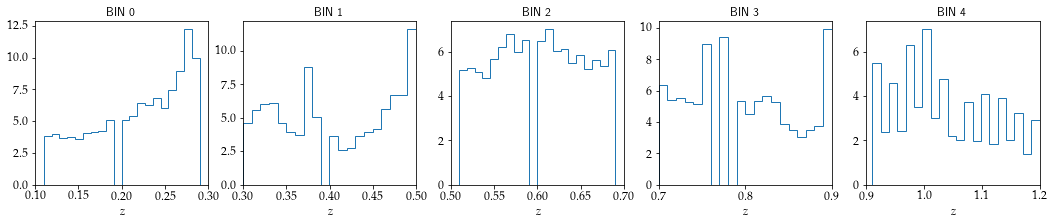

In [21]:
plot_quantities(config, all_bins_data, 'redshift', zmethod = 'Z_B', xlabel = r'$z$', uselog=False)

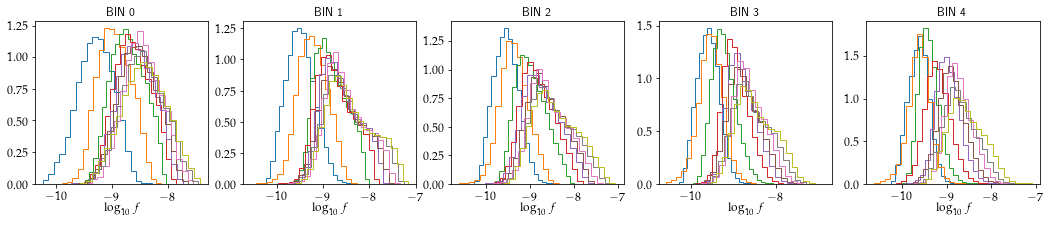

In [22]:
plot_quantities(config, all_bins_data, 'flux', xlabel = r'$f$', uselog=True)

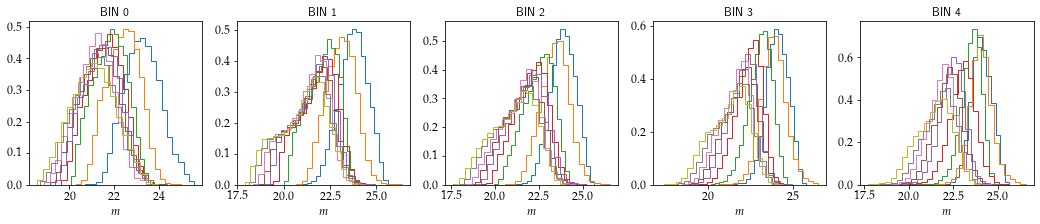

In [23]:
plot_quantities(config, all_bins_data, 'mag', xlabel = r'$m$', uselog=False)